In [ ]:
%load_ext autoreload
%autoreload 2

# NOTE: This notebook contains 2 parts: COVET and MetaQ
# COVET part of this notebook and MetaQ Part of this code needs to be run in separate environments
# requirements_scenvi.txt file provides the list of modules needed to create venv for COVET part. Use Python version: 3.10.19

#creating an environment: 

# --- FOR WINDOWS ---
# python -m venv venv

# --- FOR macOS / LINUX ---
# python3 -m venv venv

#Use these commands for activating virtual environments:

# --- FOR WINDOWS (Command Prompt / cmd.exe) ---
# venv\Scripts\activate.bat

# --- FOR WINDOWS (PowerShell) ---
# venv\Scripts\Activate.ps1
# Note: If you get a permission error, run: Set-ExecutionPolicy Unrestricted -Scope Process

# --- FOR macOS / LINUX (Bash or Zsh) ---
# source venv/bin/activate



# Installing libraries using any requirements file (requirements.txt is shown as an example)
# pip install -r requirements.txt

#deactivating environments:
# deactivate

In [7]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0" # Change to -1 if you want to use CPU!

import warnings
warnings.filterwarnings('ignore')

In [8]:
import scenvi

In [9]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import scanpy as sc
import umap.umap_ as umap


## Data

Downloading Motor Cortex scRNA-seq and MERFISH data from the Pe'er lab aws and loading in with scanpy

In [13]:
# For downloading sc_data and st_data
!wget https://dp-lab-data-public.s3.amazonaws.com/ENVI/sc_data.h5ad
!wget https://dp-lab-data-public.s3.amazonaws.com/ENVI/st_data.h5ad

In [10]:
st_data = sc.read_h5ad('st_data.h5ad')
sc_data = sc.read_h5ad('sc_data.h5ad')
sc_data = sc_data[:20000, :2000]

In [11]:
sc_data

View of AnnData object with n_obs × n_vars = 20000 × 2000
    obs: 'aggr_num', 'umi.counts', 'gene.counts', 'library_id', 'tube_barcode', 'Seq_batch', 'Region', 'Lib_type', 'Gender', 'Donor', 'Amp_Name', 'Amp_Date', 'Amp_PCR_cyles', 'Lib_Name', 'Lib_Date', 'Replicate_Lib', 'Lib_PCR_cycles', 'Lib_PassFail', 'Cell_Capture', 'Lib_Cells', 'Mean_Reads_perCell', 'Median_Genes_perCell', 'Median_UMI_perCell', 'Saturation', 'Live_percent', 'Total_Cells', 'Live_Cells', 'method', 'exp_component_name', 'mapped_reads', 'unmapped_reads', 'nonconf_mapped_reads', 'total.reads', 'doublet.score', 'cluster_label', 'subclass_label', 'class_label', 'cell_type', 'cell_label'

Defining cell type color palette

In [12]:
cell_type_palette = {'Astro': (0.843137, 0.0, 0.0, 1.0),
                     'Endo': (0.54902, 0.235294, 1.0, 1.0),
                     'L23_IT': (0.007843, 0.533333, 0.0, 1.0),
                     'L45_IT': (0.0, 0.67451, 0.780392, 1.0),
                     'L56_NP': (0.596078, 1.0, 0.0, 1.0),
                     'L5_ET': (1.0, 0.498039, 0.819608, 1.0),
                     'L5_IT': (0.423529, 0.0, 0.309804, 1.0),
                     'L5_PT': (1.0, 0.647059, 0.188235, 1.0),
                     'L6_CT': (0.345098, 0.231373, 0.0, 1.0),
                     'L6_IT': (0.0, 0.341176, 0.34902, 1.0),
                     'L6_IT_Car3': (0.0, 0.0, 0.866667, 1.0),
                     'L6b': (0.0, 0.992157, 0.811765, 1.0),
                     'Lamp5': (0.631373, 0.458824, 0.415686, 1.0),
                     'Microglia': (0.737255, 0.717647, 1.0, 1.0),
                     'OPC': (0.584314, 0.709804, 0.470588, 1.0),
                     'Oligo': (0.752941, 0.015686, 0.72549, 1.0),
                     'Pericytes': (0.392157, 0.329412, 0.454902, 1.0),
                     'Pvalb': (0.47451, 0.0, 0.0, 1.0),
                     'SMC': (0.027451, 0.454902, 0.847059, 1.0),
                     'Sncg': (0.996078, 0.960784, 0.564706, 1.0),
                     'Sst': (0.0, 0.294118, 0.0, 1.0),
                     'VLMC': (0.560784, 0.478431, 0.0, 1.0),
                     'Vip': (1.0, 0.447059, 0.4, 1.0)}

cell_label_palette = {'GABAergic': (0.843137, 0.0, 0.0, 1.0),
                      'Glutamatergic': (0.54902, 0.235294, 1.0, 1.0),
                      'Non-Neuronal': (0.007843, 0.533333, 0.0, 1.0)}

## Running ENVI

We first define and ENVI model which computes the COVET matrices of the spatial data and intializes the CVAE:

In [13]:
envi_model = scenvi.ENVI(spatial_data = st_data, sc_data = sc_data, covet_batch_size = 256)

Preparing gene sets for ENVI analysis...
Identified 2048 highly variable genes from single-cell data
Gene selection: 25 shared genes, 1840 unique to single-cell
Computing Niche Covariance Matrices
Using log-transformed gene expression for COVET calculation
Computing COVET using all 25 genes
Log-transforming expression data from X


Computing matrix square roots: 100%|████████| 1081/1081 [00:15<00:00, 69.14it/s]


Finished Initializing ENVI


Training ENVI and run auxiliary function

In [14]:
envi_model.train()
envi_model.impute_genes()
envi_model.infer_niche_covet()
envi_model.infer_niche_celltype()

 spatial: -5.679e-01 sc: -7.914e-01 cov: -1.247e-02 kl: 6.576e-01: 100%|█| 10000


Computing latent representations


Encoding: 100%|███████████████████████████████| 313/313 [00:03<00:00, 89.52it/s]


Imputing missing genes for spatial data


Decoding expression: 100%|██████████████████| 4322/4322 [00:59<00:00, 72.29it/s]


Infering niche COVET representation for single-cell data


Decoding covet: 100%|█████████████████████████| 313/313 [00:05<00:00, 59.56it/s]


Infering cell type niche composition for single cell data


Read ENVI predictions

In [15]:
st_data.obsm['envi_latent'] = envi_model.spatial_data.obsm['envi_latent']
st_data.obsm['COVET'] = envi_model.spatial_data.obsm['COVET']
st_data.obsm['COVET_SQRT'] = envi_model.spatial_data.obsm['COVET_SQRT']
st_data.uns['COVET_genes'] =  envi_model.CovGenes
st_data.obsm['imputation'] = envi_model.spatial_data.obsm['imputation']
st_data.obsm['cell_type_niche'] = envi_model.spatial_data.obsm['cell_type_niche']

sc_data.obsm['envi_latent'] = envi_model.sc_data.obsm['envi_latent']
sc_data.obsm['COVET'] = envi_model.sc_data.obsm['COVET']
sc_data.obsm['COVET_SQRT'] = envi_model.sc_data.obsm['COVET_SQRT']
sc_data.obsm['cell_type_niche'] = envi_model.sc_data.obsm['cell_type_niche']
sc_data.uns['COVET_genes'] =  envi_model.CovGenes

In [17]:
st_data_sst = st_data[st_data.obs['cell_type'] == 'Sst']
sc_data_sst = sc_data[sc_data.obs['cell_type'] == 'Sst']

In [18]:
gran_sst_palette = {'Th': (0.0, 0.294118, 0.0, 1.0),
                    'Calb2': (0.560784, 0.478431, 0.0, 1.0),
                    'Chodl': (1.0, 0.447059, 0.4, 1.0),
                    'Myh8': (0.933333, 0.72549, 0.72549, 1.0),
                    'Crhr2': (0.368627, 0.494118, 0.4, 1.0),
                    'Hpse': (0.65098, 0.482353, 0.72549, 1.0),
                    'Hspe': (0.352941, 0.0, 0.643137, 1.0),
                    'Crh': (0.607843, 0.894118, 1.0, 1.0),
                    'Pvalb Etv1': (0.92549, 0.0, 0.466667, 1.0)}

In [19]:
import scipy.sparse 



In [20]:
def flatten(x):
    return(x.reshape([x.shape[0], -1]))

def run_diffusion_maps(data_df, n_components=10, knn=30, alpha=0):
    """Run Diffusion maps using the adaptive anisotropic kernel
    :param data_df: PCA projections of the data or adjacency matrix
    :param n_components: Number of diffusion components
    :param knn: Number of nearest neighbors for graph construction
    :param alpha: Normalization parameter for the diffusion operator
    :return: Diffusion components, corresponding eigen values and the diffusion operator
    """

    # Determine the kernel
    N = data_df.shape[0]

    if(type(data_df).__module__ == np.__name__):
        data_df = pd.DataFrame(data_df)

    if not scipy.sparse.issparse(data_df):
        print("Determing nearest neighbor graph...")
        temp = sc.AnnData(data_df.values)
        sc.pp.neighbors(temp, n_pcs=0, n_neighbors=knn)
        kNN = temp.obsp['distances']

        # Adaptive k
        adaptive_k = int(np.floor(knn / 3))
        adaptive_std = np.zeros(N)

        for i in np.arange(len(adaptive_std)):
            adaptive_std[i] = np.sort(kNN.data[kNN.indptr[i] : kNN.indptr[i + 1]])[
                adaptive_k - 1
            ]

        # Kernel
        x, y, dists = scipy.sparse.find(kNN)

        # X, y specific stds
        dists = dists / adaptive_std[x]
        W = scipy.sparse.csr_matrix((np.exp(-dists), (x, y)), shape=[N, N])

        # Diffusion components
        kernel = W + W.T
    else:
        kernel = data_df

    # Markov
    D = np.ravel(kernel.sum(axis=1))

    if alpha > 0:
        # L_alpha
        D[D != 0] = D[D != 0] ** (-alpha)
        mat = scipy.sparse.csr_matrix((D, (range(N), range(N))), shape=[N, N])
        kernel = mat.dot(kernel).dot(mat)
        D = np.ravel(kernel.sum(axis=1))

    D[D != 0] = 1 / D[D != 0]
    T = scipy.sparse.csr_matrix((D, (range(N), range(N))), shape=[N, N]).dot(kernel)
    # Eigen value dcomposition
    D, V = scipy.sparse.linalg.eigs(T, n_components, tol=1e-4, maxiter=1000)
    D = np.real(D)
    V = np.real(V)
    inds = np.argsort(D)[::-1]
    D = D[inds]
    V = V[:, inds]

    # Normalize
    for i in range(V.shape[1]):
        V[:, i] = V[:, i] / np.linalg.norm(V[:, i])

    return V[:, 1:]

In [21]:
DC_COVET = run_diffusion_maps(np.concatenate([flatten(st_data_sst.obsm['COVET_SQRT']), 
                                              flatten(sc_data_sst.obsm['COVET_SQRT'])], axis = 0))

st_data_sst.obsm['DC_COVET'] = DC_COVET[:st_data_sst.shape[0]]
sc_data_sst.obsm['DC_COVET'] = DC_COVET[st_data_sst.shape[0]:]

Determing nearest neighbor graph...


In [22]:
# Define filenames for your processed data
spatial_filename = "sc_data_with_covet_results.h5ad"

# --- 1. Save your Spatial Data (The one you need for MetaQ) ---
print(f"Saving spatial data (with envi_latent) to: {spatial_filename}")
sc_data.write(spatial_filename)


print("\n--- All Done! ---")
print("Your files are saved. You can safely shut down this notebook.")

Saving spatial data (with envi_latent) to: sc_data_with_covet_results.h5ad

--- All Done! ---
Your files are saved. You can safely shut down this notebook.


In [23]:
st_data_sst.obsm['DC_COVET'] = -DC_COVET[:st_data_sst.shape[0]]
sc_data_sst.obsm['DC_COVET'] = -DC_COVET[st_data_sst.shape[0]:]

In [25]:
depth_df = pd.DataFrame()
depth_df['Subtype'] = sc_data_sst.obs['cluster_label']
depth_df['Depth'] = -sc_data_sst.obsm['DC_COVET'][:,0]

In [26]:
subtype_depth_order = depth_df.groupby(['Subtype']).mean().sort_values(by = 'Depth', ascending=False).index

## Niche Cell Type Composition

In [27]:
subtype_canonical = pd.DataFrame([sc_data_sst[sc_data_sst.obs['cluster_label']==subtype].obsm['cell_type_niche'].mean(axis = 0) for subtype in subtype_depth_order],
                                     index = subtype_depth_order, columns = sc_data.obsm['cell_type_niche'].columns)

In [28]:
subtype_canonical[subtype_canonical<0.2] = 0
subtype_canonical.drop(labels=subtype_canonical.columns[(subtype_canonical == 0).all()], axis=1, inplace=True)
subtype_canonical = subtype_canonical.div(subtype_canonical.sum(axis=1), axis=0)

In [30]:

# Define filenames for your processed data
spatial_filename = "st_data_20kcells_with_covet.h5ad"

# --- 1. Save your Spatial Data (The one you need for MetaQ) ---
print(f"Saving spatial data (with envi_latent) to: {spatial_filename}")
st_data.write(spatial_filename)

# --- 2. Save your Single-Cell Data (Good to keep) ---

print("\n--- All Done! ---")
print("Your files are saved. You can safely shut down this notebook.")

Saving spatial data (with envi_latent) to: st_data_20kcells_with_covet.h5ad

--- All Done! ---
Your files are saved. You can safely shut down this notebook.


## MetaQ metacell inference

In [2]:
#From this part, run using another venv
# requirements_metaq.txt file provides the list of modules needed to create venv for the MetaQ part. Use Python version: 3.11.14
#Please create two folders: saves and figures in the same directory as the notebook
# There will be a FileNotFoundError, but please ignore it, the MetaQ would have successfully run

import scanpy as sc
import warnings
import anndata
from MetaQ_sc import run_metaq
from sklearn.preprocessing import MinMaxScaler 

warnings.filterwarnings("ignore")

spatial_filename = "sc_data_with_covet_results.h5ad" 
print(f"Loading processed data from: {spatial_filename}")

st_data = sc.read(spatial_filename)
print("Data loaded.")

latent_features = st_data.obsm['envi_latent']

print("Scaling latent features to be all positive...")
scaler = MinMaxScaler(feature_range=(0, 10))
scaled_latent_features = scaler.fit_transform(latent_features)

adata_for_metaq = anndata.AnnData(X=scaled_latent_features)
adata_for_metaq.obs_names = st_data.obs_names

print("\nCreated a new AnnData object for MetaQ:")
print(adata_for_metaq)

metaq_input_file = "latent_data_for_metaq.h5ad"
print(f"Saving this new object to: {metaq_input_file}")
adata_for_metaq.write(metaq_input_file)



print("\nStarting MetaQ... This will create new files in ./save/ and ./figures/")
run_metaq(
    data_path=[
        metaq_input_file, 
    ],
    data_type=[
        "ATAC",  
    ],
    metacell_num=500,    
    save_name="my_spatial_metacells",
    device="cpu"        
)


Loading processed data from: sc_data_with_covet_results.h5ad
Data loaded.
Scaling latent features to be all positive...

Created a new AnnData object for MetaQ:
AnnData object with n_obs × n_vars = 20000 × 512
Saving this new object to: latent_data_for_metaq.h5ad

Starting MetaQ... This will create new files in ./save/ and ./figures/
=======Loading and Preprocessing Data=======
Data of 1 omics in total
latent_data_for_metaq.h5ad loaded with shape [20000, 512]
Target metacell number: 500
======= Training Start =======
[Epoch 20] ATAC: Loss Rec=1.7559 Loss Rec Q=1.7638 | Codebook: Loss C=0.0137
[Epoch 40] ATAC: Loss Rec=1.7360 Loss Rec Q=1.7557 | Codebook: Loss C=0.0133
[Epoch 60] ATAC: Loss Rec=1.7276 Loss Rec Q=1.7524 | Codebook: Loss C=0.0152
[Epoch 80] ATAC: Loss Rec=1.7233 Loss Rec Q=1.7507 | Codebook: Loss C=0.0088
[Epoch 100] ATAC: Loss Rec=1.7211 Loss Rec Q=1.7509 | Codebook: Loss C=0.0107
[Epoch 120] ATAC: Loss Rec=1.7195 Loss Rec Q=1.7524 | Codebook: Loss C=0.0215
[Epoch 140] A

RuntimeError: "addmm_impl_cpu_" not implemented for 'Half'

Loading original data: sc_data_with_covet_results.h5ad
Loading metacell assignments: ./save/my_spatial_metacells_500metacell_ids.h5ad
Loading metacell objects: ./save/my_spatial_metacells_ATAC_500metacell.h5ad

Data combined. Ready to plot.
Calculating UMAP for the 500 metacells...
Plotting UMAP...


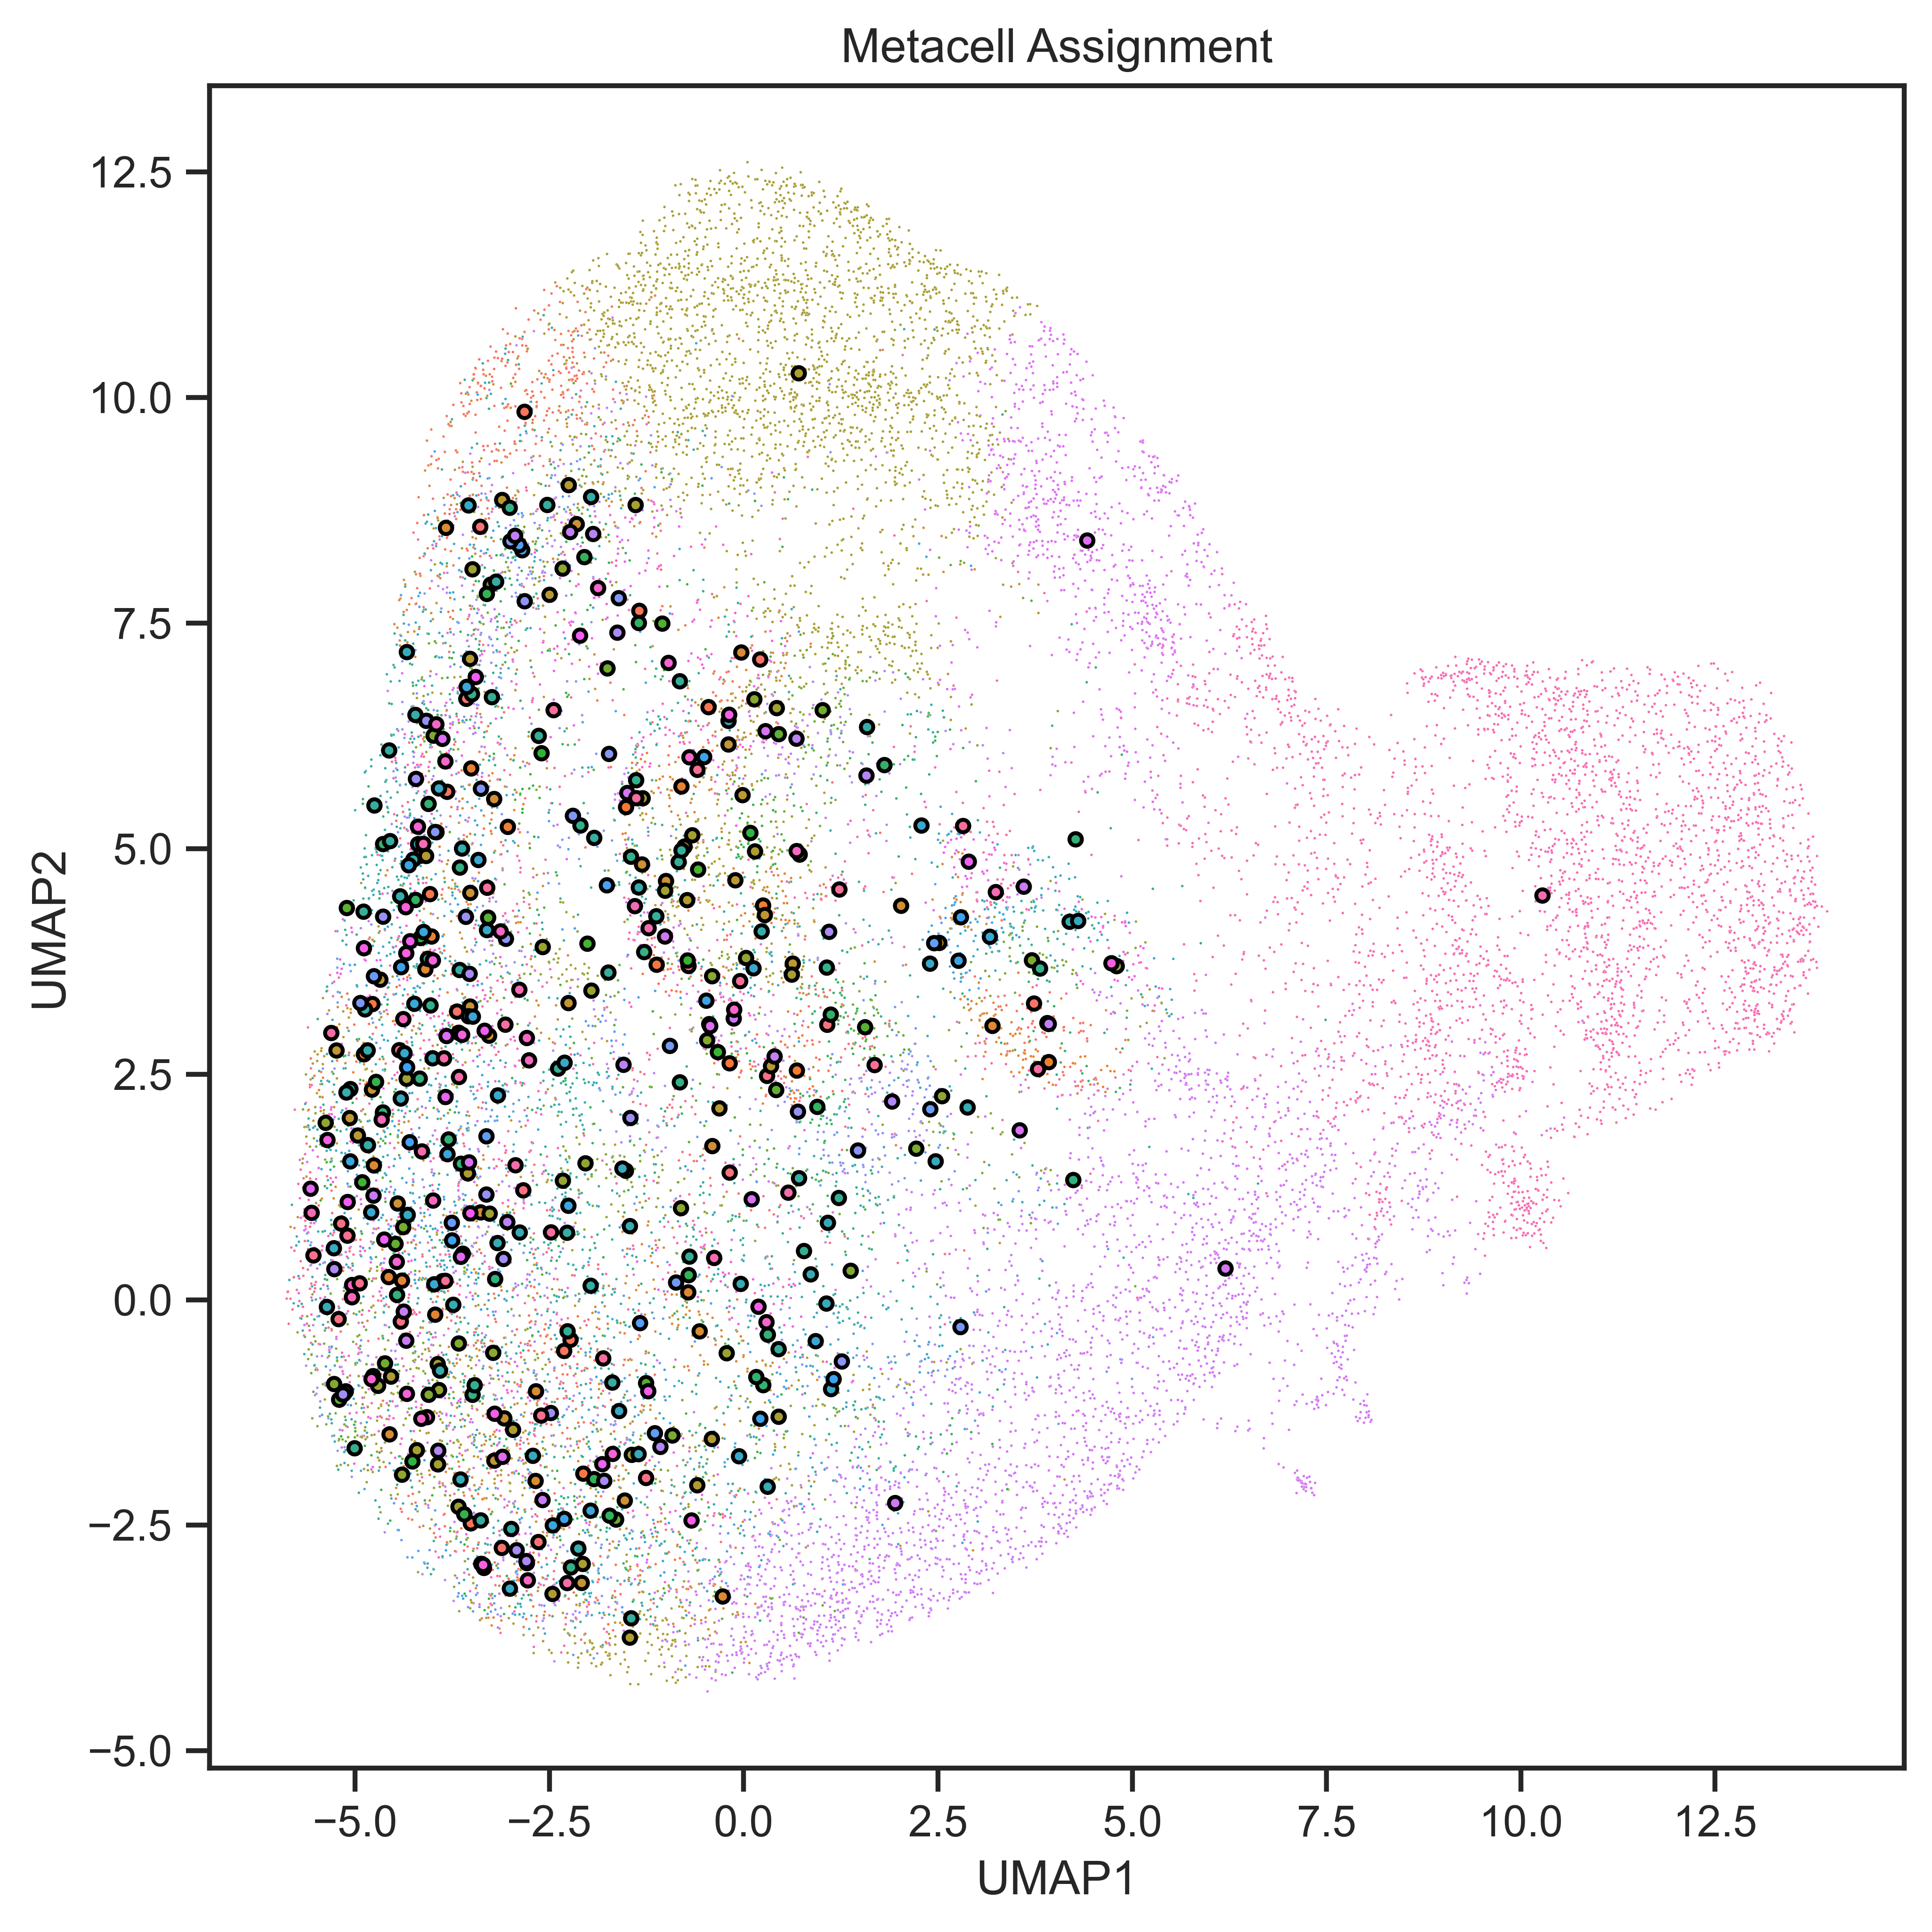

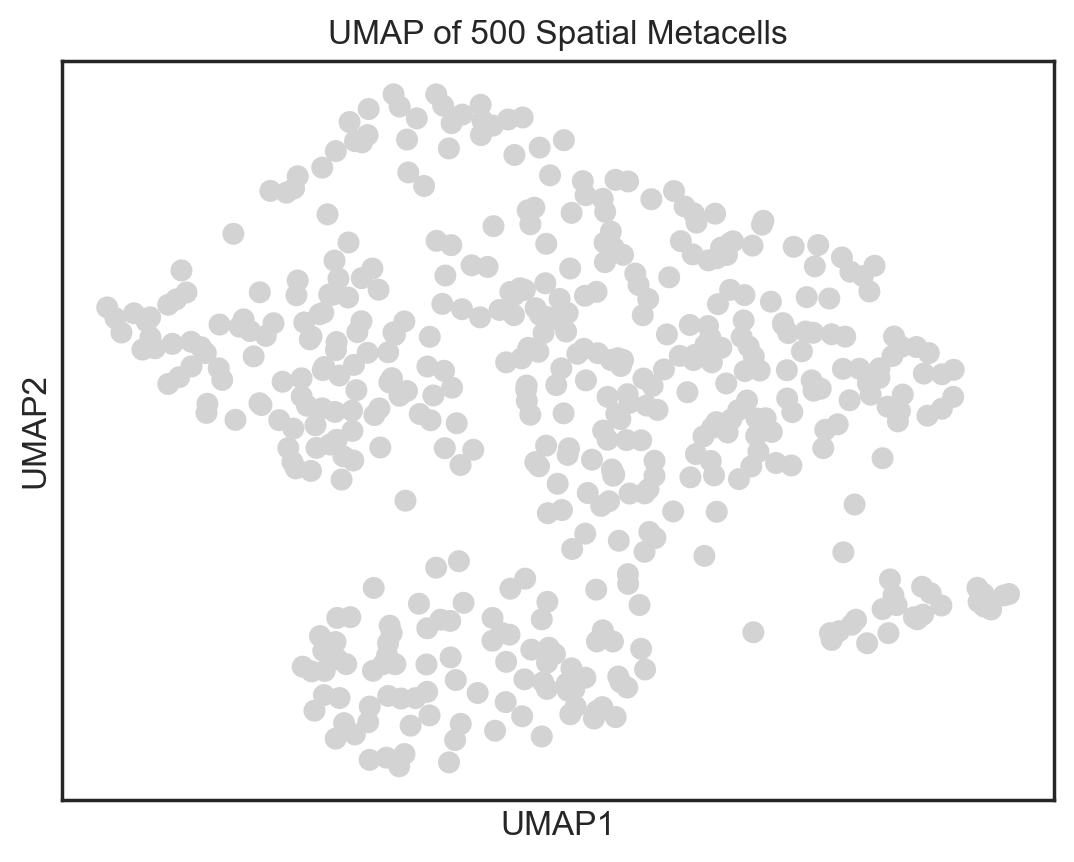

In [5]:
import scanpy as sc
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

# --- 1. Load Your Project Files ---

orig_spatial_file = "sc_data_with_covet_results.h5ad"
assign_file = "./save/my_spatial_metacells_500metacell_ids.h5ad"
meta_file = "./save/my_spatial_metacells_ATAC_500metacell.h5ad"

print(f"Loading original data: {orig_spatial_file}")
st_data = sc.read(orig_spatial_file)

print(f"Loading metacell assignments: {assign_file}")
adata_assign = sc.read(assign_file)

print(f"Loading metacell objects: {meta_file}")
adata_meta = sc.read(meta_file)


# --- 2. Combine the Data ---

# THIS LINE IS DELETED because the names don't match, but the order is correct.
# adata_assign = adata_assign[st_data.obs_names, :]

# We copy the values directly.
# I also fixed the typo: 'metacall_assignment' -> 'metacell_assignment'
st_data.obs['spatial_metacell'] = adata_assign.obs['metacell'].values
st_data.obs['spatial_metacell'] = st_data.obs['spatial_metacell'].astype('category')

print("\nData combined. Ready to plot.")

# --- 3. PLOT 1: UMAP of the 500 Metacells ---

print("Calculating UMAP for the 500 metacells...")
sc.pp.neighbors(adata_meta, use_rep='X')
sc.tl.umap(adata_meta)

print("Plotting UMAP...")
sc.pl.umap(
    adata_meta,
    title="UMAP of 500 Spatial Metacells",
    save=".png",
    palette='turbo',
)

# --- 4. PLOT 2: Spatial Plot of Metacell IDs ---

# print("Plotting spatial metacells on the tissue...")
# sc.pl.spatial(
#     st_data,
#     color='spatial_metacell',
#     title='Spatial Metacells (Projected onto Tissue)',
#     palette='turbo',
#     spot_size=30,
#     legend_loc=None,
#     save=".png"
# )